In [1]:
from typing import Callable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator

# Introduction
In this project, we explore the application of Transductive Conformal Prediction (TCP) in the context of binary classification, specifically for predicting credit card churn. Churn prediction is a critical task for financial institutions, as it helps identify customers who are likely to discontinue using their services. Effective churn prediction allows companies to engage customers and reduce attrition, improving customer retention and business sustainability.

Traditional machine learning models output point predictions, such as probabilities or class labels, but do not quantify the uncertainty associated with these predictions. This is where conformal prediction becomes valuable. Conformal prediction offers a statistically valid method to compute prediction intervals or sets that capture the uncertainty of the model's predictions, making them more interpretable and reliable.

In transductive conformal prediction, we focus on the specific test instances at hand to produce confidence intervals or prediction sets, without retraining the model. This approach offers a unique advantage in that it can generate valid prediction sets for each new instance while leveraging the model's performance on the observed data. In the context of credit card churn, TCP can provide more insightful and actionable predictions by not only identifying whether a customer might churn but also providing a level of confidence in that prediction.

Through this notebook, we will apply transductive conformal prediction to a dataset of credit card customers.

The main assumption of conformal prediction is the data points in training and test set are exchangeable.

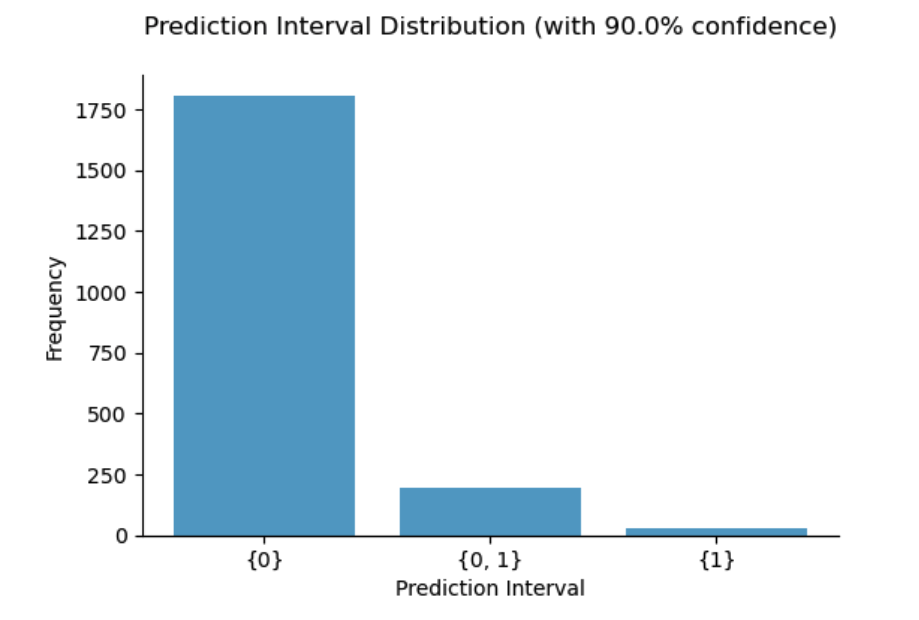

# Importing the data

In [2]:
# data source: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers
df = pd.read_csv("data/binary_classification/BankChurners.csv").drop("CLIENTNUM", axis=1)
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


# Data Cleaning

In [3]:
df.Attrition_Flag = df.Attrition_Flag.replace({'Attrited Customer':1,'Existing Customer':0})
df.Gender = df.Gender.replace({'F':1,'M':0})
# dropping latent ML data
df.drop(df.columns[-7:], axis=1, inplace=True)

### One-hot-encoding categorical variables

In [4]:
# dropping categories that have a small sample
df = pd.concat([df,pd.get_dummies(df['Education_Level']).drop(columns=['Unknown'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['Income_Category']).drop(columns=['Unknown'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['Marital_Status']).drop(columns=['Unknown'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['Card_Category']).drop(columns=['Platinum'])],axis=1)

In [5]:
df.drop(["Education_Level", "Income_Category", "Marital_Status", "Card_Category"], 
        axis=1, inplace=True)
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,...,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Divorced,Married,Single,Blue,Gold,Silver
0,0,45,0,3,39,5,1,3,12691.0,777,...,0,1,0,0,0,1,0,1,0,0
1,0,49,1,5,44,6,1,2,8256.0,864,...,0,0,0,1,0,0,1,1,0,0
2,0,51,0,3,36,4,1,0,3418.0,0,...,0,0,1,0,0,1,0,1,0,0
3,0,40,1,4,34,3,4,1,3313.0,2517,...,0,0,0,1,0,0,0,1,0,0
4,0,40,0,3,21,5,1,0,4716.0,0,...,0,1,0,0,0,1,0,1,0,0


# Declaring target variable, splitting into training and test and training the model

In [6]:
X = df.drop("Attrition_Flag", axis=1)
y = df.Attrition_Flag
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

### Printing coefficients (Just for fun, not relevant to the CP-framework)

In [7]:
pd.DataFrame(model.coef_, columns=df.drop("Attrition_Flag", axis=1).columns).T.rename(columns={0: "Logistic regression coefficients"})

,Logistic regression coefficients
Customer_Age,0.133152
Gender,0.230093
Dependent_count,0.109046
Months_on_book,-0.100031
Total_Relationship_Count,-0.519827
Months_Inactive_12_mon,0.413726
Contacts_Count_12_mon,0.653657
Credit_Limit,-0.095747
Total_Revolving_Bal,-0.752657
Avg_Open_To_Buy,-0.028251


# Transductive conformal prediction for one case demo

In [8]:
X_train_plus_test = np.concatenate([X_train, X_test[0].reshape(1, -1)])

y_train_plus_test_0 = np.append(y_train, 0)
y_train_plus_test_1 = np.append(y_train, 1)

## Training the model for the customer not leaving, i.e. 0

In [9]:
model.fit(X_train_plus_test, y_train_plus_test_0)
y_pred_score_train_plus_test_0 = model.predict_proba(X_train_plus_test)

## Training the model of the customer leaving, i.e. 1

In [10]:
model.fit(X_train_plus_test, y_train_plus_test_1)
y_pred_score_train_plus_test_1 = model.predict_proba(X_train_plus_test)

# Deriving the nonconformity score, i.e. the strangeness score

### In this binary classification problem we're using hinge loss:
$$g(y_i, x_i) = max(0, 1 - y_i * f(x_i))$$

where $y_i$ is the actual result, and $f(x_i)$ is the model prediction

In [11]:
def hinge_loss(predicted_score: iter, y: iter) -> np.array:
    """
    Computes the hinge loss for binary classification.

    Parameters:
    -----------
    predicted_score : iterable
        The predicted scores from the model for each instance. These should be 
        the raw outputs from the decision function (before applying a threshold).
    y : iterable
        The true labels for each instance, where each label should be either +1 or -1.

    Returns:
    --------
    np.array
        The computed hinge loss for each instance, given by max(0, 1 - y * predicted_score).
    """
    hinge_lst = list()
    for i, y_i in enumerate(y):
        hinge_lst.append(max([0, 1 - predicted_score[i, y_i]]))

    return np.array(hinge_lst)

In [12]:
non_conformity_scores_train_plus_test_0 = hinge_loss(y_pred_score_train_plus_test_0,
                                                     y_train_plus_test_0)

non_conformity_scores_train_plus_test_1 = hinge_loss(y_pred_score_train_plus_test_1,
                                                     y_train_plus_test_1)

In [13]:
non_conformity_scores_y_train_class_0, non_conformity_scores_y_test_class_0 = [non_conformity_scores_train_plus_test_0[:-1],
                                        non_conformity_scores_train_plus_test_0[-1]]

non_conformity_scores_y_train_class_1, non_conformity_scores_y_test_class_1 = [non_conformity_scores_train_plus_test_1[:-1],
                                        non_conformity_scores_train_plus_test_1[-1]]


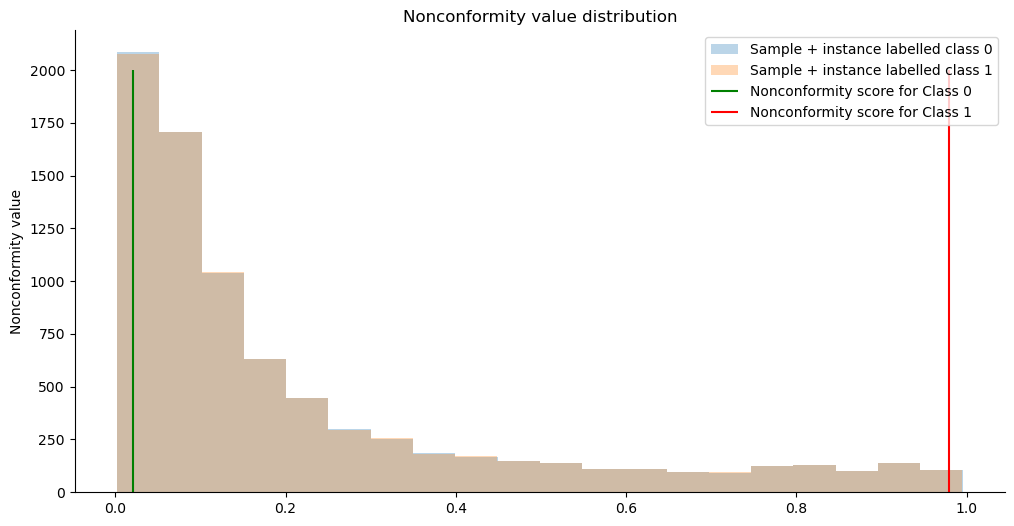

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(np.sort(non_conformity_scores_y_train_class_0), label='Sample + instance labelled class 0', 
         alpha=0.3, bins=20)
ax.hist(np.sort(non_conformity_scores_y_train_class_1), label='Sample + instance labelled class 1', 
         alpha=0.3, bins=20)
# single line
ax.vlines(x = non_conformity_scores_y_test_class_0, ymin = 0, ymax = 2e3, color="green",
           label = 'Nonconformity score for Class 0')

ax.vlines(x = non_conformity_scores_y_test_class_1, ymin = 0, ymax = 2e3, color="red",
           label = 'Nonconformity score for Class 1')

ax.set_ylabel('Nonconformity value')
plt.title('Nonconformity value distribution')

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.legend( loc='upper right')
plt.show()

The histogram plots shows the nonconformity distribution of the ML model trained on the new instance but with differing labels. A higher value on the x-axis displays a larger "strangeness" of the new observation. In this case, by the  the model doesn't think the prediction of 0 is un-normal, but would categorize a 1 prediction as highly strange. To mathematically test whether case 1 would be in the prediction interval, we derive the p-value.

# Deriving the p-value:
Using the p-value definition as in Manokhin's book:
$$p(y) = \frac{|\{i : \alpha_i \geq \alpha_T(y)\}|}{n + 1}$$

where $\alpha_T(y)$ is the nonconformity score for the test instance $T$, $n$ is the current training sample size and the plus one is because of the unobserved test instance. 

In [15]:
def compute_p_value(non_conformity_scores_train: np.array, non_conformity_scores_test: float) -> float:
    """
    Calculates the p-value for a new non-conformity score based on previously observed non-conformity scores.

    Parameters:
    -----------
    non_conformity_scores_train : np.array
        The non-conformity scores from the training set (used to evaluate how typical or atypical a new observation is).
    non_conformity_scores_test : float
        The non-conformity score for the new test instance that needs to be evaluated.

    Returns:
    --------
    float
        The p-value representing the proportion of training non-conformity scores that are greater than or equal 
        to the test instance's non-conformity score. This value indicates how unusual the test instance is relative 
        to the training data.
    """    
    p_values = list()
 
    return (np.sum(non_conformity_scores_train >= non_conformity_scores_test) + 1) / (len(non_conformity_scores_train) +1)

In [16]:
p_value_class_0 = compute_p_value(non_conformity_scores_y_train_class_0,
                                  non_conformity_scores_y_test_class_0)
p_value_class_1 = compute_p_value(non_conformity_scores_y_train_class_1,
                                  non_conformity_scores_y_test_class_1)

In [17]:
print(f"The p-value if the first instance of the test set is negative is: {round(p_value_class_0, 3)}\
 indicating that this would be a normal case if the customer didn't leave, whereas the p-value of a \
 positive case is {round(p_value_class_1, 3)}, indicating an abnormal case if this\
  instance turned out to be a customer leaving the company.")

The p-value if the first instance of the test set is negative is: 0.931 indicating that this would be a normal case if the customer didn't leave, whereas the p-value of a  positive case is 0.002, indicating an abnormal case if this  instance turned out to be a customer leaving the company.


# Now applying TCP for all instances of the test set
This applies training the dataset on $n + m + 1$ observations, where $n$ is the observations of the original training set, and $m$ is the observations of the test set up to the current observed data plus one which is the new unobserved data we want to find a prediction interval on.

In [18]:
def new_instance_prediction(
    model: BaseEstimator, 
    X_train: pd.DataFrame, 
    X_test: pd.DataFrame, 
    y_train: pd.Series, 
    y_test: pd.Series, 
    non_conform_measure: Callable, 
    p_value_func: Callable, 
    p_value: float = 0.05
) -> pd.DataFrame:    
    """
    Conformal prediction of each new instance using the transductive approach.

    Parameters:
    -----------
    model : sklearn.base.BaseEstimator
        A trained scikit-learn model that implements a predict_proba method.
    X_train : pd.DataFrame
        The training feature set.
    X_test : pd.DataFrame
        The test feature set.
    y_train : pd.Series
        The training target labels.
    y_test : pd.Series
        The test target labels.
    non_conform_measure : Callable
        A function that computes the non-conformity measure for the model's predictions.
    p_value_func : Callable
        A function to calculate p-values based on the non-conformity measures.
    p_value : float, optional
        The significance level (default is 0.05) for computing the prediction intervals.

    Returns:
    --------
    pd.DataFrame
        A DataFrame with prediction intervals for each new instance in X_test, 
        with a confidence level of (1 - p_value).
    """
    pred_interval = list()
    for i in range(len(y_test)):
        sample_X_plus_new_instance = np.concatenate([X_train, X_test[:i + 1]])
        sample_y = np.concatenate([y_train, y_test[:i]])
        sample_y_plus_class_0 = np.append(sample_y, 0)
        sample_y_plus_class_1 = np.append(sample_y, 1)
    
    # deriving p-value for class 0:
        model.fit(sample_X_plus_new_instance, sample_y_plus_class_0)
        y_pred_score_plus_class_0 = model.predict_proba(sample_X_plus_new_instance)
        nonconf_val_0 = non_conform_measure(y_pred_score_plus_class_0, sample_y_plus_class_0)
    # checking the strangeness of the last instance compared to the actual sample
        p_value_class_0 = p_value_func(nonconf_val_0[:-1], nonconf_val_0[-1])
    
    # prediction for class 1:
        model.fit(sample_X_plus_new_instance, sample_y_plus_class_1)
        y_pred_score_plus_class_1 = model.predict_proba(sample_X_plus_new_instance)
        nonconf_val_1 = non_conform_measure(y_pred_score_plus_class_1, sample_y_plus_class_1)
    # checking the strangeness of the last instance compared to the actual sample
        p_value_class_1 = p_value_func(nonconf_val_1[:-1], nonconf_val_1[-1])
    
        row_instance = list()
        row_instance.append(0) if p_value_class_0 >= p_value else np.nan
        row_instance.append(1) if p_value_class_1 >= p_value else np.nan
        if len(row_instance) == 0:
            print(p_value_class_0)
            print(p_value_class_1)
        pred_interval.append([row_instance, y_test.iloc[i]])
    
    return pd.DataFrame(pred_interval, columns=["Prediction Interval", "Actual"])

# Case where we want to be 90% sure that the prediction is within the prediction interval 

In [19]:
%%time
confidence_level = 0.9
p_value = 1 - confidence_level
df_interval = new_instance_prediction(model, X_train, X_test, y_train, y_test, hinge_loss, 
                        p_value_func=compute_p_value, p_value=p_value)

print("The prediction interval distribution: ")
print(df_interval["Prediction Interval"].value_counts())

wrong_predictions = len(df_interval[df_interval.apply(lambda x: x["Actual"] not in x["Prediction Interval"], axis=1)])
print(f"Number of predictions which turned out to be wrong: {wrong_predictions}")

print(f"which means: {wrong_predictions / len(df_interval) * 100}% of the predictions\
 were wrong")
print("")

The prediction interval distribution: 
[0]       1803
[0, 1]     192
[1]         31
Name: Prediction Interval, dtype: int64
Number of predictions which turned out to be wrong: 200
which means: 9.871668311944719% of the predictions were wrong

CPU times: user 5min 58s, sys: 1min 16s, total: 7min 15s
Wall time: 55.9 s


## Bar plot for visualization

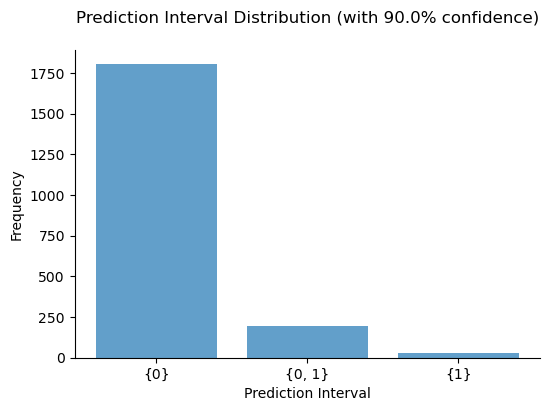

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
X_axis = ["{0}", "{0, 1}", "{1}"]
y_axis = df_interval["Prediction Interval"].value_counts().values

ax.bar(X_axis, y_axis, align="center", alpha=0.7)

plt.title(f"Prediction Interval Distribution (with {confidence_level * 100}% confidence)", pad=20)

ax.set_ylabel("Frequency")
ax.set_xlabel("Prediction Interval")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()

# Case where we want to be 95% sure that the prediction is within the prediction interval

In [21]:
%%time
confidence_level = 0.95
p_value = 1 - confidence_level
df_interval = new_instance_prediction(model, X_train, X_test, y_train, y_test, hinge_loss, 
                        p_value_func=compute_p_value, p_value=p_value)

print("The prediction interval: ")
print(df_interval["Prediction Interval"].value_counts())

wrong_predictions = len(df_interval[df_interval.apply(lambda x: x["Actual"] not in x["Prediction Interval"], axis=1)])
print(f"Number of predictions which turned out to be wrong: {wrong_predictions}")

print(f"which means: {wrong_predictions / len(df_interval) * 100}% of the predictions\
 were wrong")
print("")

The prediction interval: 
[0]       1376
[0, 1]     645
[1]          5
Name: Prediction Interval, dtype: int64
Number of predictions which turned out to be wrong: 115
which means: 5.676209279368213% of the predictions were wrong

CPU times: user 5min 58s, sys: 1min 14s, total: 7min 12s
Wall time: 54.8 s


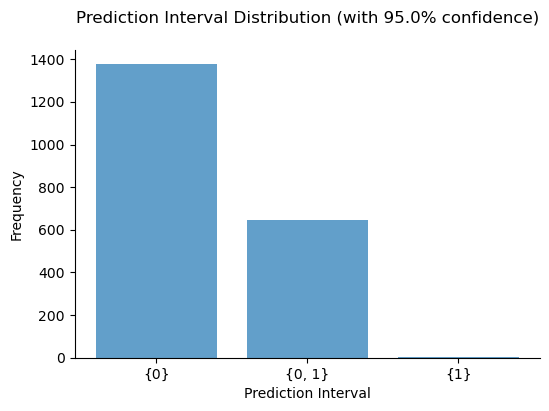

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))
X_axis = ["{0}", "{0, 1}", "{1}"]
y_axis = df_interval["Prediction Interval"].value_counts().values

ax.bar(X_axis, y_axis, align="center", alpha=0.7)

plt.title(f"Prediction Interval Distribution (with {confidence_level * 100}% confidence)", pad=20)

ax.set_ylabel("Frequency")
ax.set_xlabel("Prediction Interval")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()

# Case where we want to be 99.9% sure that the prediction is within the prediction interval 

In [23]:
%%time

confidence_level = 0.999
p_value = 1 - confidence_level
df_interval = new_instance_prediction(model, X_train, X_test, y_train, y_test, hinge_loss, 
                        p_value_func=compute_p_value, p_value=p_value)

print("The prediction interval: ")
print(df_interval["Prediction Interval"].value_counts())

wrong_predictions = len(df_interval[df_interval.apply(lambda x: x["Actual"] not in x["Prediction Interval"], axis=1)])
print(f"Number of predictions which turned out to be wrong: {wrong_predictions}")

print(f"which means: {wrong_predictions / len(df_interval) * 100}% of the predictions\
 were wrong")
print(" ")

The prediction interval: 
[0, 1]    1954
[0]         72
Name: Prediction Interval, dtype: int64
Number of predictions which turned out to be wrong: 3
which means: 0.14807502467917077% of the predictions were wrong
 
CPU times: user 5min 58s, sys: 1min 14s, total: 7min 13s
Wall time: 54.9 s


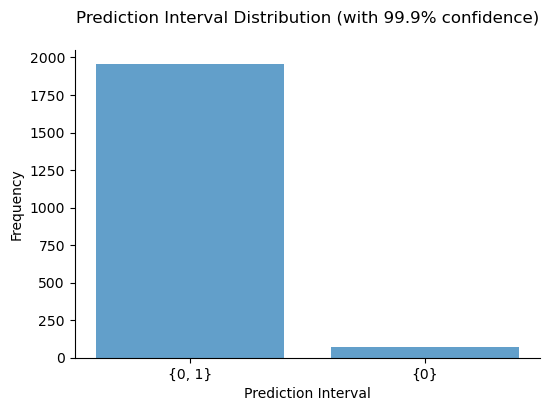

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
X_axis = ["{0, 1}", "{0}"]
y_axis = df_interval["Prediction Interval"].value_counts().values

ax.bar(X_axis, y_axis, align="center", alpha=0.7)

plt.title(f"Prediction Interval Distribution (with {confidence_level * 100}% confidence)", pad=20)

ax.set_ylabel("Frequency")
ax.set_xlabel("Prediction Interval")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()

## Conclusion:
Naturally the prediction intervals will contain more of both labels as the confidence level increases. I find it interesting how accurate the number of wrong predictions are with the confidence level even with quite a low sample size as this dataset has.